# Implémentation du réseau de neurones et expérimentation

In [4]:
import numpy as np
from sklearn import datasets

## 0. Implémentation de fonctions utiles
Calcul numériquement stable du softmax

In [5]:
def softmax_vector(x):
    '''
    x:  is a data vector.
    returns: the result of the softmax function applied to the data vector.
    '''
    max_comp = np.amax(x)
    normalized  = x - max_comp
    
    exponential = np.exp(normalized)
    
    return exponential/np.sum(exponential)

In [71]:
def softmax(X):
    '''
    X: matrix that holds the data, every row is a data vector.
    returns: matrix where every row is the result of the softmax function applied to the corresponding data vector.
    '''
    
    max_comp = np.amax(X, axis=1)
    normalized  = X - max_comp.reshape(X.shape[0], 1)
    
    exponential = np.exp(normalized)
    
    return exponential/np.sum(exponential, axis=1).reshape(X.shape[0], 1)

Fonction utilitaire pour calculer relu($x$)

In [7]:
def relu(x):
    return np.maximum(x, np.zeros(x.shape))

def onehot(m, y):
    return np.eye(m)[y]

def onehot_matrix(m, targets):
    """
    Returns: onehot matrix where every column is a onehot vector of the coressponding target
    """
    eye = np.eye(m)
    onehot_matrix = np.zeros((m,len(targets)))
    
    for i, y in enumerate(targets):
        onehot_matrix[:,i] = eye[y]
        
    return onehot_matrix

## 1. Calcul du gradient sur un exemple

Implementation de fprop et bprop pour calculer le gradient sur un exemple

In [8]:
class NeuralNet_basic:
    
    def __init__(self, n_input, n_hidden, n_out):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, x):
        '''Computes activations for every layer'''
        self.ha = self.W1.dot(x) + self.b1
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2
        self.os = softmax_vector(self.oa)
            
    def bprop(self, x, y):
        '''Computes the gradients, must be executed after fprop'''
                      
        grad_oa = self.os - onehot(self.n_o, y)
        grad_b2 = grad_oa
        grad_W2 = np.outer(grad_oa, self.hs)
        grad_hs = self.W2.T.dot(grad_oa)
        grad_ha = grad_hs * (self.ha > 0)
        grad_W1 = np.outer(grad_ha, x)
        grad_b1 = grad_ha
        
        return grad_W1, grad_W2, grad_b1, grad_b2

## 2. Vérification du gradient par différences finies

On va maintenant vérifier que le gradient calculé par Keras est juste. Pour cela on va calculer une approximation du gradient en utilisant la méthode de la différence finie.

Pour chaque composante de w1, on va:
 1. calculer la valeur de la fonction objectif $L$
 2. ajouter une petite valeur $\epsilon$ à la composante
 3. recalculer la valeur de la fonction objectif $L'$
 4. remettre à l'ancienne valeur la composante (c'est à dire soustraire $\epsilon$)

Le gradient par différences finies sera dans ce cas donné par:
$\Big( \frac{\partial L}{\partial W_{1}} \Big)_{ij} = \frac{1}{\epsilon} (L' - L)$

In [9]:
def compute_loss(x, y, W1, W2, b1, b2):
    ha = W1.dot(x) + b1
    hs = relu(ha)
    oa = W2.dot(hs) + b2
    os = softmax_vector(oa)
    
    return -np.log(os[y])

Fonction pour calculer le gradient par differences finies

In [10]:
def finite_diff(x, y, neural_net, eps=1e-5):
    
    # params
    W1 = neural_net.W1
    W2 = neural_net.W2
    b1 = neural_net.b1
    b2 = neural_net.b2
    
    # gradients
    grad_w1_diff = np.zeros(W1.shape)
    grad_w2_diff = np.zeros(W2.shape)
    grad_b1_diff = np.zeros(b1.shape)
    grad_b2_diff = np.zeros(b2.shape)
    
    neural_net.fprop(x)
    loss = compute_loss(x, y, W1, W2, b1, b2)
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1[i,j] = W1[i,j] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_w1_diff[i, j] = (loss_prime - loss) / epsilon
            W1[i,j] = W1[i,j] - eps
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2[i,j] = W2[i,j] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_w2_diff[i, j] = (loss_prime - loss) / epsilon
            W2[i,j] = W2[i,j] - eps
    for i in range(b1.shape[0]):
            b1[i] = b1[i] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_b1_diff[i] = (loss_prime - loss) / epsilon
            b1[i] = b1[i] - eps
    for i in range(b1.shape[0]):
            b2[i] = b2[i] + eps
            loss_prime = compute_loss(x, y, W1, W2, b1, b2)
            grad_b2_diff[i] = (loss_prime - loss) / epsilon
            b2[i] = b2[i] - eps
            
    return grad_w1_diff, grad_w2_diff, grad_b1_diff, grad_b2_diff
    

Affichage de vérification du gradient par différence finie

In [11]:
data = np.loadtxt(open('2moons.txt','r'))

In [12]:
nn = NeuralNet_basic(2, 2, 2)
x = data[0,:-1]
y = data[0,-1]
epsilon = 1e-5

# gradients par différence finie
grad_w1_diff, grad_w2_diff, grad_b1_diff, grad_b2_diff = finite_diff(x, y, nn, epsilon)

# gradients par implémentation dans classe neural_net
grad_W1, grad_W2, grad_b1, grad_b2 = nn.bprop(x,y)

# affichage de la différence
print(grad_w1_diff)
print(grad_W1)
print(grad_W1 - grad_w1_diff)
print(grad_W2 - grad_w2_diff)
print(grad_b1 - grad_b1_diff)
print(grad_b2 - grad_b2_diff)

[[-0.12444391  0.61155682]
 [ 0.04155129 -0.20419507]]
[[-0.124444    0.61155464]
 [ 0.04155128 -0.20419531]]
[[ -9.01766750e-08  -2.17807174e-06]
 [ -1.00650309e-08  -2.42815719e-07]]
[[ -4.65345068e-07  -1.82888643e-06]
 [ -4.65332689e-07  -1.82888766e-06]]
[ -6.75445985e-07  -7.52954557e-08]
[ -1.24275700e-06  -1.24275479e-06]


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 3. Ajout de hyperparamètre de taille de lot K
La fonction bprop est modifiée pour calculer le gradient sur un batch d'exemple. La fonction train est également ajoutée.

In [78]:
class NeuralNet_loop:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K = 1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.K = K
        self.lambdas = lambdas
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        np.random.seed(123)
        
        # Initialize the parameters
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, x):
        '''Computes activations for every layer'''
        self.ha = self.W1.dot(x) + self.b1
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2
        self.os = softmax_vector(self.oa)
            
    def bprop(self, X, Y):
        '''Computes the gradients over all examples in (X,Y) with loop'''
        grad_W1_mean = np.zeros((self.n_h, self.n_in))
        grad_W2_mean = np.zeros((self.n_o, self.n_h))
        grad_b1_mean = np.zeros(self.n_h)
        grad_b2_mean = np.zeros(self.n_o)
        
        n = X.shape[0]
        
        for i in range(n):
            
            self.fprop(X[i,:])
            
            grad_oa = self.os - onehot(self.n_o, Y[i])
            grad_b2 = grad_oa
            grad_W2 = np.outer(grad_oa, self.hs)
            grad_hs = self.W2.T.dot(grad_oa)
            grad_ha = grad_hs * (self.ha > 0)
            grad_W1 = np.outer(grad_ha, X[i,:])
            grad_b1 = grad_ha
            
            grad_W1_mean = grad_W1_mean + grad_W1 / n
            grad_W2_mean = grad_W2_mean + grad_W2 / n
            grad_b1_mean = grad_b1_mean + grad_b1 / n
            grad_b2_mean = grad_b2_mean + grad_b2 / n
        
        return grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean
    
    def compute_loss(self, y):
        return -np.log(self.os[y])
    
    def train(self, train_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        # Initialize batch start and end indices
        batch_start = 0
        if (batch_start + self.K < train_data.shape[0]):
            batch_end = batch_start + self.K
        else:
            batch_end = train_data.shape[0]
        
        for i in range(max_iter):
            for j in range(n_batches):
                batch = train_data[batch_start:batch_end]
                
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean = self.bprop(batch[:,:-1], batch[:,-1]) 
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                
                # Get next batch
                batch_start = batch_end + 1        
                if (batch_start + self.K < train_data.shape[0]):
                    batch_end = batch_start + self.K
                else:
                    batch_end = train_data.shape[0]
                    
    def compute_predictions(self, test_data):

        pred = np.empty((test_data.shape[0],self.n_o))

        for i in range(test_data.shape[0]):
            self.fprop(test_data[i,:])
            pred[i,:] = self.os

        return pred


## 4. Vérification du gradient par différence finie

Affichage de vérification du gradient pour un lot de 10 exemples

In [14]:
lambdas = np.array([[0, 0],
       [0, 0]])
nn = NeuralNet_loop(2, 2, 2, lambdas)
X = data[0:10,:-1]
Y = data[0:10,-1]

# params
W1 = nn.W1
W2 = nn.W2
b1 = nn.b1
b2 = nn.b2

# gradients par différence finie
grad_w1_diff = np.zeros(W1.shape)
grad_w2_diff = np.zeros(W2.shape)
grad_b1_diff = np.zeros(b1.shape)
grad_b2_diff = np.zeros(b2.shape)

for i in range(X.shape[0]):
    grad_w1, grad_w2, grad_b1, grad_b2 = finite_diff(X[i,:], Y[i], nn, epsilon)
    grad_w1_diff += grad_w1 / X.shape[0]
    grad_w2_diff += grad_w2 / X.shape[0]
    grad_b1_diff += grad_b1 / X.shape[0]
    grad_b2_diff += grad_b2 / X.shape[0]
    
# gradients par implémentation dans classe neural_net    
grad_W1, grad_W2, grad_b1, grad_b2 = nn.bprop(X,Y)

# affichage de la différence
print(grad_w1_diff)
print(grad_W1)
print(grad_W1 - grad_w1_diff)

[[-0.00682624  0.01188266]
 [-0.01188135 -0.07664923]]
[[-0.00682624  0.01188265]
 [-0.01188137 -0.07664959]]
[[ -2.55917080e-09  -1.13768918e-08]
 [ -2.10081357e-08  -3.62971216e-07]]


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 5. Entraînement sur 2 moons et visualisation des régions de décision

Fonction de calcul du taux d'erreur de classification

In [15]:
#Cette fonction renvoie le taux d'erreur étant donné un classifieur et un ensemble de données
def taux_erreur(classifieur, data):
    data_prob = classifieur.compute_predictions(data[:,:-1])
    data_classe_pred = np.argmax(data_prob, axis = 1)
    #print(data_prob[1:20,:])
    #print(data_classe_pred[1:20])
    return 100*float(sum(sum([data_classe_pred != data[:,-1]])))/data.shape[0]

Fonction d'affichage des régions de décision 

In [25]:
# fonction plot
import pylab
def gridplot(classifieur,train,test,n_points=50):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))

    les_comptes = classifieur.compute_predictions(thegrid)
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    pylab.pcolormesh(xgrid, ygrid, classesPred.reshape((n_points, n_points)).T, alpha=.3)
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50)
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50)

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1, = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=5) 
    h2, = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=5) 
    h3, = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=5) 
    handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    pylab.legend(handles,labels)

    pylab.axis('equal')
    pylab.show()
    
## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout


Entraînement sur les données 2 moons

In [32]:
import random

ntrain = 2* (data.shape[0] // 3)

inds = [i for i in range(data.shape[0])]
np.random.seed(123)
np.random.shuffle(inds)

test_inds = inds[:ntrain]
validation_inds = inds[ntrain:]

#On définit l'ensemble d'entraînement et l'ensemble de validation
train_data = data[test_inds,]
validation_data = data[validation_inds,]

#Variation de la valeur des hyperparamètres K et eta
lambdas = np.array([[0.0000001, 0.0000001],
       [0.0000001, 0.0000001]])

def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
        
erreurs = np.zeros([15,10])
i = 0
#eta = 0.1
for K in range(50,700,50):
    j = 0
    for eta in frange(0.1,1,0.1):
        nn = NeuralNet_loop(2,20,2,lambdas, K)   
        nn.train(train_data,100000,eta)  
        #erreurs[i,0] = 0.01*taux_erreur(nn, validation_data)
        #print(nn.W1)
        #print(nn.W2)
        #print(nn.b1)
        #print(nn.b2)
        erreurs[i,j] = 0.01*taux_erreur(nn, validation_data)
        j = j + 1
    i = i + 1
print(erreurs)

C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[ 0.27717391  0.23641304  0.24184783  0.22282609  0.22282609  0.21467391
   0.2201087   0.2201087   0.27717391  0.3423913 ]
 [ 0.43478261  0.24456522  0.23913043  0.24184783  0.22554348  0.22826087
   0.22826087  0.21467391  0.22826087  0.22282609]
 [ 0.21467391  0.27173913  0.24184783  0.23641304  0.21467391  0.23097826
   0.2173913   0.26902174  0.26358696  0.22554348]
 [ 0.3125      0.33152174  0.24728261  0.2173913   0.23913043  0.24184783
   0.2201087   0.20380435  0.25543478  0.23641304]
 [ 0.27173913  0.27173913  0.31521739  0.2798913   0.24184783  0.25815217
   0.23913043  0.22826087  0.23369565  0.23641304]
 [ 0.3423913   0.42391304  0.23913043  0.36413043  0.27445652  0.25815217
   0.24728261  0.30163043  0.26358696  0.24728261]
 [ 0.26086957  0.24456522  0.31521739  0.29076087  0.26358696  0.28804348
   0.2173913   0.2201087   0.23913043  0.22826087]
 [ 0.48369565  0.2173913   0.26358696  0.2201087   0.30978261  0.25543478
   0.26902174  0.23641304  0.26086957  0.26358696]


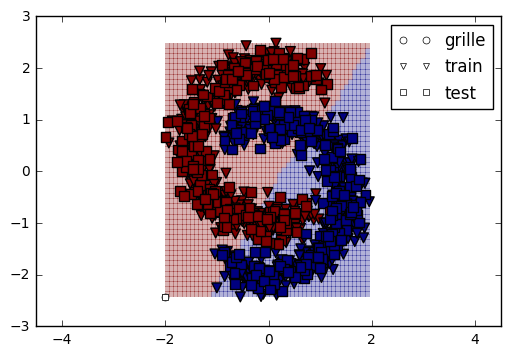

[[  5.48700852e-01   2.70402560e-01]
 [  2.12823396e-01  -1.40400827e-01]
 [ -5.52145968e-01   4.17253613e-01]
 [ -5.15154400e-01  -5.22723920e-01]
 [  6.27634076e-01   4.16300416e-01]
 [ -1.16470809e-01   5.59582048e-02]
 [ -8.19903188e-02   1.81026598e-01]
 [ -2.38870502e-01  -1.64195620e-01]
 [ -6.46616309e-02   2.79105124e-02]
 [ -4.52828338e-01  -3.50631809e-01]
 [ -3.62520182e-01  -8.71076022e-02]
 [  5.62844954e-01  -3.00318580e-01]
 [  4.43383238e-01  -1.93425589e-01]
 [ -6.42213990e-02  -5.06577580e-01]
 [ -2.47584050e-01   1.72063279e-08]
 [  4.66790862e-08  -1.73266797e-01]
 [  1.84732307e-02   6.84250727e-01]
 [  5.15691620e-01  -6.22529799e-01]
 [  2.49167740e-01   4.79593712e-02]
 [  3.01374887e-01  -6.11096776e-01]]
[[ -3.59584711e-02  -1.06616951e-01  -1.17084375e-01  -1.98084662e-01
    2.14135040e-01   5.41115988e-02   2.61828794e-08  -1.22971290e-01
   -1.73020757e-01  -5.73293022e-02   6.45749737e-02   2.03760613e-01
    6.85737955e-02   6.65072263e-02   5.52814791e

In [33]:
gridplot(nn, train_data, validation_data, 50)
print(nn.W1)
print(nn.W2)
print(nn.b1)
print(nn.b2)

## 6. Implémentation du calcul de gradient avec expressions matricielles

$\mathbf{W}^{(1)} \in \mathbb{R}^{d_h \times d}$, $\mathbf{X} \in \mathbb{R}^{n \times d}$ et $\mathbf{B}^{(1)} \in \mathbb{R}^{d_h \times n}$

$$\mathbf{h}^{a} = \mathbf{W}^{(1)}\mathbf{X}^{\top} + \mathbf{B}^{(1)} \in \mathbb{R}^{d_h \times n}$$


In [196]:
class NeuralNetVectorized:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K=1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.lambdas = lambdas
        self.K = K
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        np.random.seed(123)
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, X):
        '''
        Computes activations for every layer
        X: input data set
        '''
        self.ha = self.W1.dot(X.T) + self.b1.reshape(self.n_h, 1)
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2.reshape(self.n_o, 1)
        self.os = np.transpose(softmax(self.oa.T))
            
    def bprop(self, X, Y):
        '''
        Computes the gradients, must be executed after fprop
        X: Input data set
        Y: targets
        '''
        n = X.shape[0]
                      
        grad_oa = self.os - onehot_matrix(self.n_o, Y)
        grad_b2 = np.sum(grad_oa, axis =1) # m x n
        grad_W2 = np.dot(grad_oa, self.hs.T) # sum of gradients grad_W2 for each example
        grad_hs = self.W2.T.dot(grad_oa) # d_h x n
        grad_ha = grad_hs * (self.ha > 0) # d_h x n
        grad_W1 = np.dot(grad_ha, X) # sum of gradients grad_W1 for each example
        grad_b1 = np.sum(grad_ha, axis =1) # d_h x n
        
        return grad_W1 / n, grad_W2 / n, grad_b1 / n, grad_b2 / n #returns average of the gradient
    
    def compute_loss(self, Y):
        loss = 0
        for i in range(Y.shape[0]):
            loss = loss -np.log(self.os[Y[i],i])
        return loss
    
    def train(self, train_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        # Initialize batch start and end indices
        batch_start = 0
        if (batch_start + self.K < train_data.shape[0]):
            batch_end = batch_start + self.K
        else:
            batch_end = train_data.shape[0]
        
        for i in range(max_iter):
            for j in range(n_batches):
                
                batch = train_data[batch_start:batch_end]
                
                self.fprop(batch[:,:-1])
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean = self.bprop(batch[:,:-1], batch[:,-1]) 
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                
                
                # Get next batch
                batch_start = batch_end + 1        
                if (batch_start + self.K < train_data.shape[0]):
                    batch_end = batch_start + self.K
                else:
                    batch_end = train_data.shape[0]
                    
    def compute_predictions(self, test_data):
        self.fprop(test_data)
        pred = self.os

        return pred



## 7. Comparaison du gradient des deux implémentations

In [131]:
#initialize a neural network of each implementation, with K=1 and K=10
for K in range(1,11,9):
    lambdas = np.array([[0, 0],
           [0, 0]])
    nn_loop = NeuralNet_loop(2,2,2,lambdas, K)
    nn_matrix = NeuralNetVectorized(2,2,2,lambdas,K)
    
    #gradient with loop implementation
    grad_W1_loop, grad_W2_loop, grad_b1_loop, grad_b2_loop = nn_loop.bprop(train_data[:,:-1],train_data[:,-1])
    
    #gradient with matrix multiplications implementation
    nn_matrix.fprop(train_data[:,:-1])
    grad_W1_mat, grad_W2_mat, grad_b1_mat, grad_b2_mat = nn_matrix.bprop(train_data[:,:-1],train_data[:,-1])
    
    #print comparison of all gradients
    print(grad_W1_loop)
    print(grad_W1_mat)
    print(grad_W1_loop - grad_W1_mat)

    print(grad_W2_loop)
    print(grad_W2_mat)
    print(grad_W2_loop - grad_W2_mat)

    print(grad_b1_loop)
    print(grad_b1_mat)
    print(grad_b1_loop - grad_b1_mat)

    print(grad_b2_loop)
    print(grad_b2_mat)
    print(grad_b2_loop - grad_b2_mat)


[[ 0.06451412 -0.06900175]
 [ 0.04133331 -0.04728092]]
[[ 0.06451412 -0.06900175]
 [ 0.04133331 -0.04728092]]
[[  1.38777878e-17   6.93889390e-17]
 [ -1.38777878e-17  -2.77555756e-17]]
[[-0.10498392  0.0524078 ]
 [ 0.10498392 -0.0524078 ]]
[[-0.10498392  0.0524078 ]
 [ 0.10498392 -0.0524078 ]]
[[ -1.11022302e-16   1.38777878e-17]
 [  1.11022302e-16  -6.93889390e-18]]
[ 0.05953552 -0.03744815]
[ 0.05953552 -0.03744815]
[  2.08166817e-17  -2.08166817e-17]
[-0.06300307  0.06300307]
[-0.06300307  0.06300307]
[ -1.38777878e-17   1.38777878e-17]
[[ 0.06451412 -0.06900175]
 [ 0.04133331 -0.04728092]]
[[ 0.06451412 -0.06900175]
 [ 0.04133331 -0.04728092]]
[[  1.38777878e-17   6.93889390e-17]
 [ -1.38777878e-17  -2.77555756e-17]]
[[-0.10498392  0.0524078 ]
 [ 0.10498392 -0.0524078 ]]
[[-0.10498392  0.0524078 ]
 [ 0.10498392 -0.0524078 ]]
[[ -1.11022302e-16   1.38777878e-17]
 [  1.11022302e-16  -6.93889390e-18]]
[ 0.05953552 -0.03744815]
[ 0.05953552 -0.03744815]
[  2.08166817e-17  -2.08166817e-

C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## 8. Comparaison du temps de calcul pour une époque quand K=100

Fetch MNIST dataset

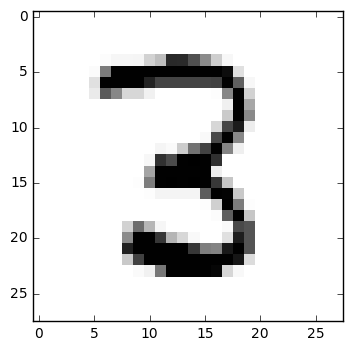

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('mnist-original', data_home='/u/dift3395/sklearn_data')

plt.imshow(mnist.data[21455,:].reshape(28, 28), interpolation="nearest", cmap='Greys')

Diviser le dataset MNIST en ensembles train, valid et test.

In [168]:
indices = np.random.permutation(len(mnist['target']))

print(mnist['data'].shape)

X_train = mnist['data'][indices][:50000]/255.
X_valid = mnist['data'][indices][50000:60000]/255.
X_test = mnist['data'][indices][60000:]/255.
y_train = mnist['target'][indices][:50000]
y_valid = mnist['target'][indices][50000:60000]
y_test = mnist['target'][indices][60000:]

#from keras.utils import np_utils
#y_train = np_utils.to_categorical(y_train)
#y_valid = np_utils.to_categorical(y_valid)
#y_test = np_utils.to_categorical(y_test)

#concatenate data and target into one np.array
train = np.concatenate((X_train, np.reshape(y_train, (50000,1))), axis=1)
valid = np.concatenate((X_valid, np.reshape(y_valid, (10000,1))), axis=1)
test = np.concatenate((X_test, np.reshape(y_test, (10000,1))), axis=1)

print(train.shape)
print(train_data.shape)

(70000, 784)
(50000, 785)
(732, 3)


In [169]:
#initializing neural networks
nn_loop = NeuralNet_loop(784,20,10,lambdas,100)
nn_matrix = NeuralNetVectorized(784,20,10,lambdas,100)

#train both neural networks
import time
start_time = time.time()
nn_loop.train(train,1,0.05)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
nn_matrix.train(train,1,0.05)
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


--- 5.578999996185303 seconds ---


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


--- 0.6069998741149902 seconds ---


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: RuntimeWarning: invalid value encountered in sign
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:76: RuntimeWarning: invalid value encountered in sign


## 9. Calcul de taux d'erreur de classification sur MNIST

Modification de la classe NeuralNetworkVectorized pour calculer les valeurs recherchées à chaque époque de la phase l'entraînement

In [224]:
class NeuralNetVectorized2:
    
    def __init__(self, n_input, n_hidden, n_out, lambdas, K=1):
        
        self.n_in = n_input
        self.n_h = n_hidden
        self.n_o = n_out
        self.lambdas = lambdas
        self.K = K
        
        low_bound = -1 / np.sqrt([self.n_in, self.n_h])
        up_bound = 1 / np.sqrt([self.n_in, self.n_h])
        
        # Initialize the parameters
        np.random.seed(123)
        self.W1 = np.random.uniform(low_bound[0], up_bound[0], size=(self.n_h, self.n_in))  # d_h x d
        self.W2 = np.random.uniform(low_bound[1], up_bound[1], size=(self.n_o, self.n_h))  # m x d_h
        self.b1 = np.zeros(self.n_h)  # dimension d_h
        self.b2 = np.zeros(self.n_o) # dimension m
    
    def fprop(self, X):
        '''
        Computes activations for every layer
        X: input data set
        '''
        self.ha = self.W1.dot(X.T) + self.b1.reshape(self.n_h, 1)
        self.hs = relu(self.ha)
        self.oa = self.W2.dot(self.hs) + self.b2.reshape(self.n_o, 1)
        self.os = np.transpose(softmax(self.oa.T))
            
    def bprop(self, X, Y):
        '''
        Computes the gradients, must be executed after fprop
        X: Input data set
        Y: targets
        '''
        n = X.shape[0]
                      
        grad_oa = self.os - onehot_matrix(self.n_o, Y)
        grad_b2 = np.sum(grad_oa, axis =1) # m x n
        grad_W2 = np.dot(grad_oa, self.hs.T) # sum of gradients grad_W2 for each example
        grad_hs = self.W2.T.dot(grad_oa) # d_h x n
        grad_ha = grad_hs * (self.ha > 0) # d_h x n
        grad_W1 = np.dot(grad_ha, X) # sum of gradients grad_W1 for each example
        grad_b1 = np.sum(grad_ha, axis =1) # d_h x n
        
        return grad_W1 / n, grad_W2 / n, grad_b1 / n, grad_b2 / n #returns average of the gradient
    
    def compute_loss(self, Y):
        ind = [i for i in range(Y.shape[0])]
        loss = self.os[Y.astype(int),ind]
        return np.sum(-np.log(loss))
    
    def train(self, train_data, valid_data, test_data, max_iter, eta=0.05):
        
        n_batches = int(np.ceil(train_data.shape[0]/self.K)) # number of batches
        
        # Initialize batch start and end indices
        batch_start = 0
        if (batch_start + self.K < train_data.shape[0]):
            batch_end = batch_start + self.K
        else:
            batch_end = train_data.shape[0]
        
        for i in range(max_iter):
            for j in range(n_batches):
                
                batch = train_data[batch_start:batch_end]
                
                self.fprop(batch[:,:-1])
                grad_W1_mean, grad_W2_mean, grad_b1_mean, grad_b2_mean = self.bprop(batch[:,:-1], batch[:,-1]) 
                
                n = len(batch)
                
                #regularization
                penality_grad_W1 = self.lambdas[0][0] * np.sign(self.W1) + 2 * self.lambdas[0][1] * self.W1
                penality_grad_W2 = self.lambdas[1][0] * np.sign(self.W2) + 2 * self.lambdas[1][1] * self.W2
                
                self.W1 = self.W1 - eta * (grad_W1_mean + penality_grad_W1)
                self.W2 = self.W2 - eta * (grad_W2_mean + penality_grad_W2)
                self.b1 = self.b1 - eta * grad_b1_mean
                self.b2 = self.b2 - eta * grad_b2_mean
                
                
                # Get next batch
                batch_start = batch_end + 1        
                if (batch_start + self.K < train_data.shape[0]):
                    batch_end = batch_start + self.K
                else:
                    batch_end = train_data.shape[0]
                    
            self.write_in_file(train_data, valid_data, test_data)
                    
    def compute_predictions(self, test_data):
        self.fprop(test_data)
        pred = self.os

        return pred
    
    def write_in_file(self,train_data,valid_data,test_data):
        train_prob = self.compute_predictions(train_data[:,:-1])
        train_classe_pred = np.argmax(train_prob, axis = 0)  
        valid_prob = self.compute_predictions(valid_data[:,:-1])
        valid_classe_pred = np.argmax(valid_prob, axis = 0)
        test_prob = self.compute_predictions(test_data[:,:-1])
        test_classe_pred = np.argmax(test_prob, axis = 0)
        classif_erreur_train = 100*float(sum(sum([train_classe_pred != train_data[:,-1]])))/train_data.shape[0]
        classif_erreur_valid = 100*float(sum(sum([valid_classe_pred != valid_data[:,-1]])))/valid_data.shape[0]
        classif_erreur_test = 100*float(sum(sum([test_classe_pred != test_data[:,-1]])))/test_data.shape[0]
        self.fprop(train_data[:,:-1])
        loss_train = self.compute_loss(train_data[:,-1])
        print(classif_erreur_train)
        print(classif_erreur_test)
        print(classif_erreur_valid)
        print(loss_train)


In [231]:
lambdas = np.array([[0.01, 0.01],
           [0.01, 0.01]])
nn_mnist = NeuralNetVectorized2(784,64,10,lambdas,train.shape[0])

nn_mnist.fprop(train[:,:-1])
#print(nn_mnist.ha)
#print(nn_mnist.hs)
#print(nn_mnist.oa)
#print(nn_mnist.os)
print(nn_mnist.compute_loss(train[:,-1]))
nn_mnist.train(train,test,valid,3,0.01)



[[ 0.09979612  0.10650669  0.09894233 ...,  0.1078696   0.0968515
   0.10606175]
 [ 0.09309599  0.09597884  0.09037948 ...,  0.09901517  0.1008595
   0.10516727]
 [ 0.10633046  0.1053224   0.10176388 ...,  0.10236225  0.09901823
   0.09197194]
 ..., 
 [ 0.09109398  0.10286088  0.09667741 ...,  0.09577115  0.10601224
   0.10357341]
 [ 0.10150626  0.10384458  0.09472771 ...,  0.09656612  0.10517329
   0.10055443]
 [ 0.09935773  0.09979484  0.09712542 ...,  0.08989528  0.09532158
   0.09744605]]
[ 0.09109398  0.09969277  0.09667741  0.11196208  0.11492115  0.09827592
  0.09402679  0.10335965  0.10905094  0.08360193]
115689.991977


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 0.09124733  0.09987189  0.09668544  0.11195109  0.11501689  0.09835071
  0.09404481  0.10366302  0.10940311  0.08386866]
93.502
93.96
93.69
115603.913701


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in maximum
  from ipykernel import kernelapp as app


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
90.08
90.32
90.25
nan


C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:77: RuntimeWarning: invalid value encountered in sign
C:\Users\zimmae\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: RuntimeWarning: invalid value encountered in sign


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
90.08
90.32
90.25
nan


In [218]:
print(train[0:20,-1].astype(int))

[7 3 7 2 2 6 7 0 0 9 7 3 8 0 6 8 8 8 8 3]
